<a href="https://colab.research.google.com/github/colinjhorgan/MLTSA22_CHorgan/blob/main/HW7/CH_HW7_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import pylab as plt
%pylab inline

import json
import os

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/kaggle/

/content/gdrive/MyDrive/kaggle


In [ ]:
#!chmod 600 kaggle.json

In [ ]:
#Get Kaggle Username and Key
envs = json.load(open('kaggle.json','r'))
os.environ['KAGGLE_USERNAME'] = envs['username']
os.environ['KAGGLE_KEY'] = envs['key']

os.environ

environ({'CUDNN_VERSION': '8.0.5.39', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'CLOUDSDK_PYTHON': 'python3', 'LANG': 'en_US.UTF-8', 'HOSTNAME': 'df73550094c4', 'OLDPWD': '/', 'CLOUDSDK_CONFIG': '/content/.config', 'NVIDIA_VISIBLE_DEVICES': 'all', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""],"debugAdapterMultiplexerPath":"/usr/local/bin/dap_multiplexer","enableLsp":true}', 'ENV': '/root/.bashrc', 'NCCL_VERSION': '2.7.8', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'NO_GCE_CHECK': 'False', 'PWD': '/', 'HOME': '/root', 'LAST_FORCED_REBUILD': '20220407', 'DEBIAN_FRONTEND': 'noninteractive', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'GCE_METADATA_TIMEOUT': '3', 'GLIBCPP_FORCE_NEW': '1', 'TBE_CREDS_ADDR': '172.28.0.1:8008', 'SHELL': '/bin/bash', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'PYTHONWARNINGS': 'ignore:::pip._internal.cli.base_command', 'CUDA_VERSION': '11.1.1', 'NVID

In [ ]:
cd HW7/data

/content/gdrive/MyDrive/kaggle/HW7/data


In [ ]:
#Specify filenames
filenames = ['training_set.csv','training_set_metadata.csv']

#Query data using kaggle api
for file in filenames:
  !kaggle competitions download PLAsTiCC-2018 -f $file

 73% 15.0M/20.7M [00:00<00:00, 40.5MB/s]
100% 20.7M/20.7M [00:00<00:00, 47.3MB/s]
  0% 0.00/689k [00:00<?, ?B/s]
100% 689k/689k [00:00<00:00, 51.7MB/s]


In [ ]:
!unzip training_set.csv.zip

Archive:  training_set.csv.zip
  inflating: training_set.csv        


In [ ]:
#Read in data from training set
lcvs = pd.read_csv('training_set.csv')
meta = pd.read_csv('training_set_metadata.csv')

In [ ]:
lcvs.head() #confirm read-in

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [ ]:
meta.head() #confirm read-in

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


# Data Exploration

In [ ]:
#Get shape and null values of lcvs and meta
for df in [lcvs, meta]:
  print(df.shape)
  print(df.isna().sum(), '\n')

(1421705, 6)
object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64 

(7848, 12)
object_id                0
ra                       0
decl                     0
gal_l                    0
gal_b                    0
ddf                      0
hostgal_specz            0
hostgal_photoz           0
hostgal_photoz_err       0
distmod               2325
mwebv                    0
target                   0
dtype: int64 



In [ ]:
#Determine number of unique objects in lightcurve data
print(f'There are {lcvs.object_id.unique().shape[0]} objects in the Light Curve Data Set')

#Determine number of unique objects in metadata
val, counts = np.unique(meta.object_id, return_counts=True)
print(np.max(counts)) #every object id is unique

There are 7848 objects in the Light Curve Data Set
1


Above, we confirm that the number of unique objects in the lightcurve data matches the number of objects in the metadata

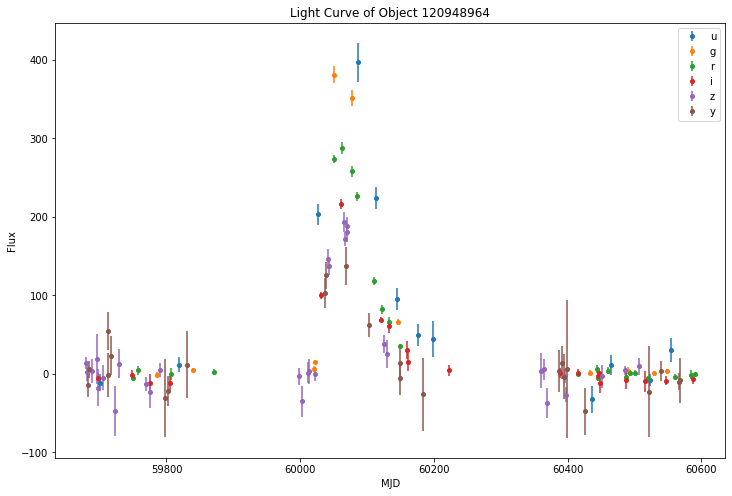

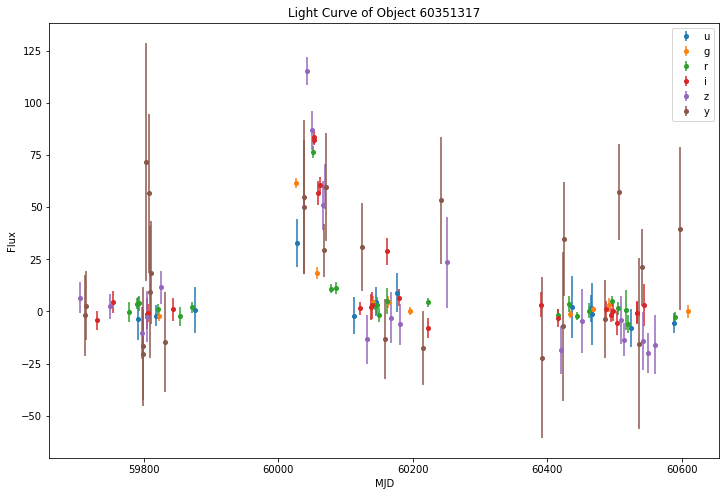

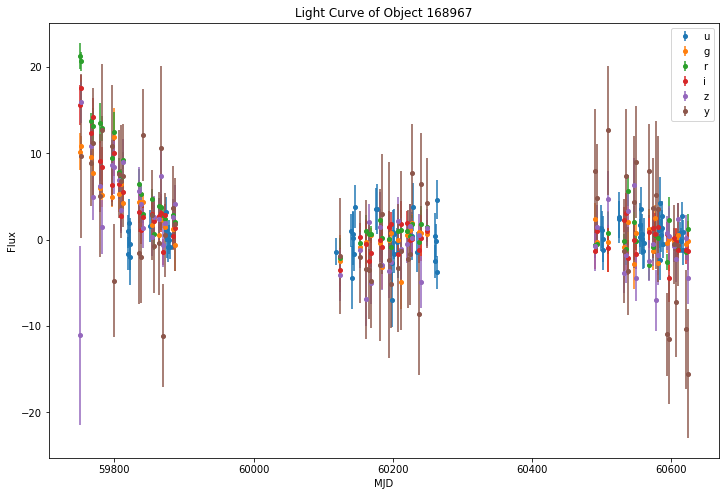

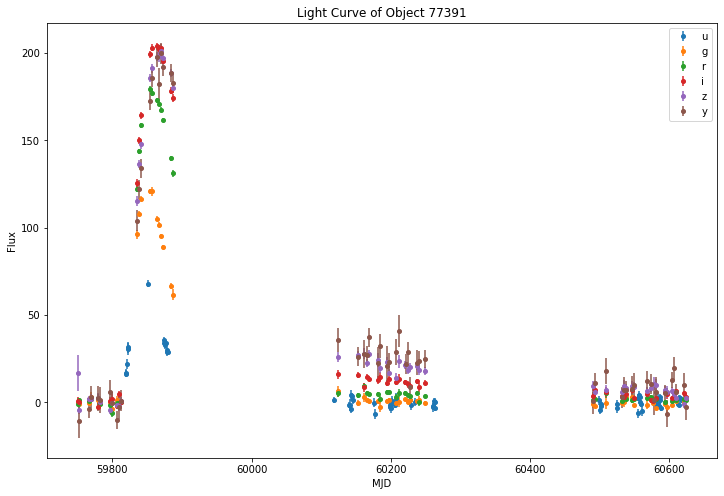

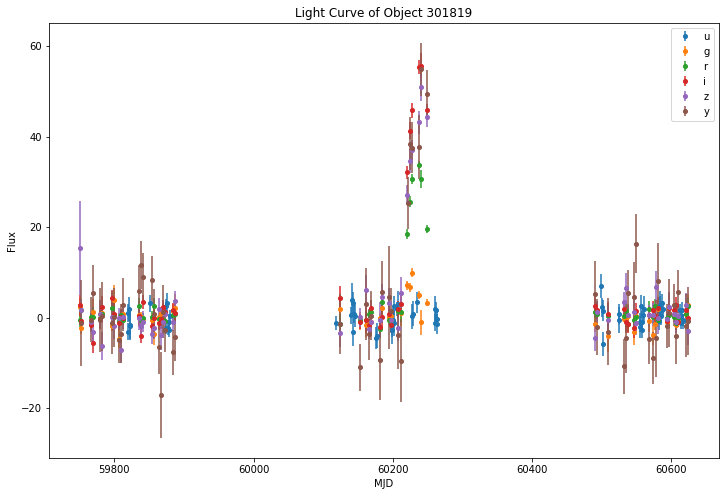

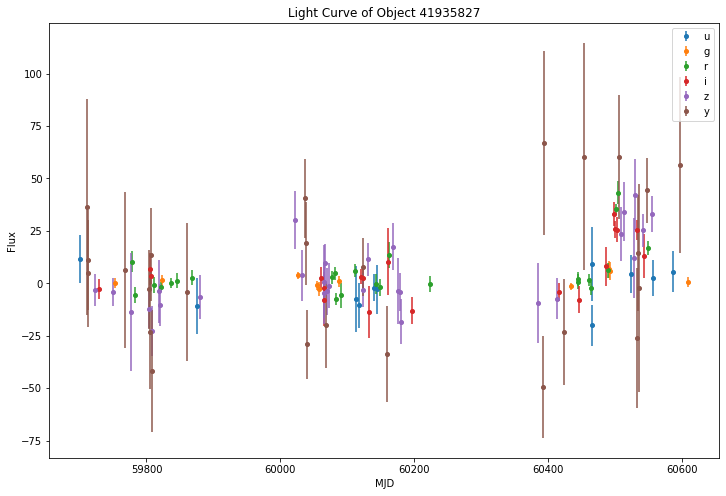

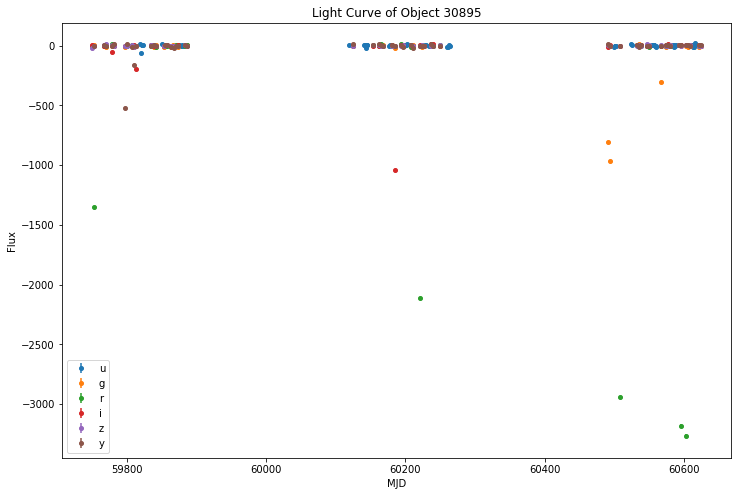

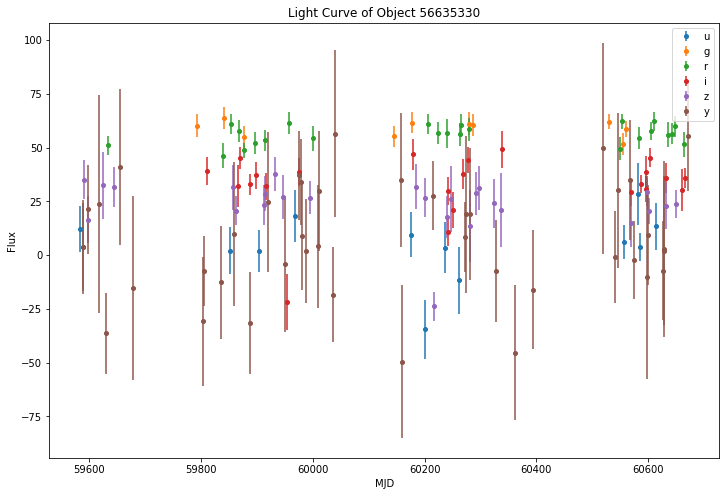

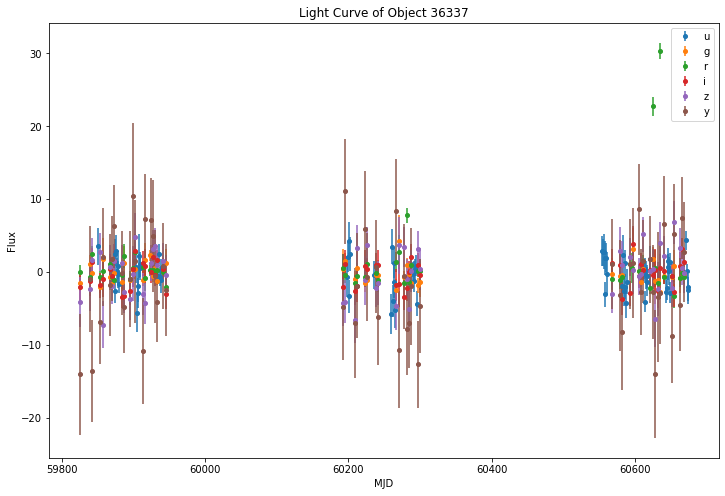

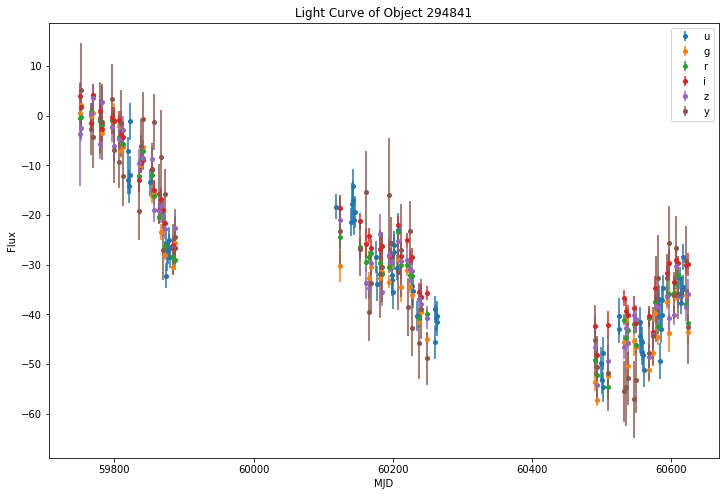

In [ ]:
#Create function for plotting light curves using flux and flux err
def plot_light_curve(df):
  labels = [c for c in 'ugrizy']
  plt.figure(figsize=(12,8))
  for c in range(0,7):
    band = df.loc[df.passband == c]
    plt.errorbar(x=band.mjd, y=band.flux, yerr=band.flux_err, marker='o',
                ls='', ms=4)
  plt.xlabel('MJD')
  plt.ylabel('Flux')
  plt.title(f'Light Curve of Object {df.object_id.values[0]}')
  plt.legend(labels);

#Plot lightcurves of 10 random objects
np.random.seed(123)
object_ids = lcvs.object_id.sample(10).values

for id in object_ids:
  obj = lcvs.loc[lcvs.object_id == id].sort_values(['passband', 'mjd'])
  plot_light_curve(obj)
  

**Figure 1:** Lightcurves of 10 random objects. Solid circles denote flux, error bars denote flux_err. Each passband is colored according to the legend. For precise band-mapping see https://www.kaggle.com/code/michaelapers?scriptVersionId=6040398&cellId=105. Note that flux error represents the 68% confidence interval for the given flux measurement.

<font color="red"> FBB good</font>

As we can see from the above plots, different objects flux accross filter can vary drastically. Interestingly the flux measurements of each object are organized into three distinct clusters which likely has to do with the visibility of each object in the sky for the telescope. The lightcurve of object 30895 (from the top) has an interesting ceiling affect around zero. Object 77391 has a distinct lightcurve in the first cluster. Exactly how to explain these affects is outside my domain of knowledge.

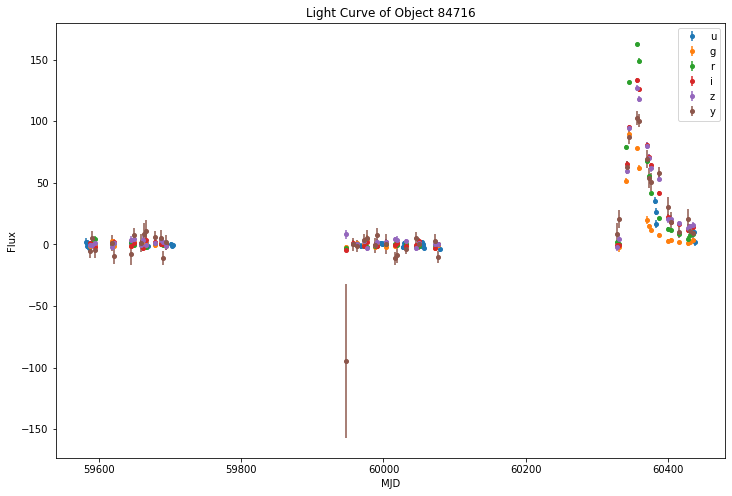

In [ ]:
#Plot specifically object 84716
spec = lcvs.loc[lcvs.object_id == 84716]
plot_light_curve(spec)

**Figure 2:** Requested plot of object 84716. Most Flux in the first 2 clusters is close to zero, with some spiking occuring in the 3rd cluster. Note the extreme outlier with the very large 68% confidence interval. In a more competitive environment removing such datapoints would likely be a worthwhile endeavor - but here we will just leave it as since defining these outliers in generality would likely be a very domain-specific task.

In [ ]:
<font color="red"> FBB good</font>

SyntaxError: ignored

# Feature Engineering

Here we extract the following features:


1.   Raw Flux
*   Mean
*   Standard Deviation
*   Skewness

We extract these features because we want to model the raw flux as a normal distribution (This is an assumption which may be dangerous - but hopefully the inclusion of skewness will save us). We take skewness as well to measure how far off 'from normal' our data is for each object/passfilter


2.   Standardized Flux
*   Median

We extract median here because its a functional measure of center on standardized data given that the mean of our data will be 0. (I expect this won't be very useful).

3.   Metadata
*    decl
*    ra

We extract these features from the metadata because they measure the 2 angles used in order for the telescope to measure a given object (raright angle, decl=declination) https://www.kaggle.com/code/michaelapers?scriptVersionId=6040398&cellId=163. knowing the exact position in the night sky an object came from might help to predict what it is.



In [ ]:
#Standardize lightcurves
lcvs['flux_stand'] = (lcvs.flux - lcvs.flux.mean()) / lcvs.flux.std()
source = lcvs.groupby(['object_id','passband']) #get groupby object to make extraction easy

#Extract mean, std, and skew from raw data and median from the standardized data
features = source.mean()[['flux']].rename(columns={'flux':'raw_mean'}) #initialize dataframe for features
features['raw_std'] = source.std()[['flux']]
features['raw_skew'] = source.skew()[['flux']]
features['stand_median'] = source.median()[['flux']]

#Unstack features so that each row contains a single object with its features 
#for all passbands as columns
features = features.unstack() #unstack multi index
new_cols = features.columns.get_level_values(0)
new_cols = [new_cols[i]+str(i%6) for i in range(0, len(new_cols))]
features.columns = new_cols

#Extract decl, hostgal_photoz, and hostgal_photoz_err
features = features.merge(meta[['object_id','decl','ra']], on='object_id')
features.shape #Note we have 28 features for each of our 7848 objects

(7848, 27)

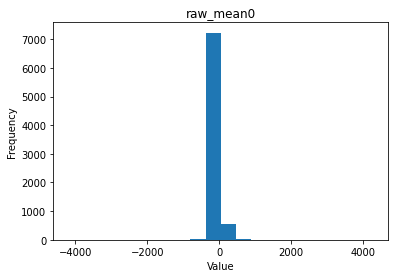

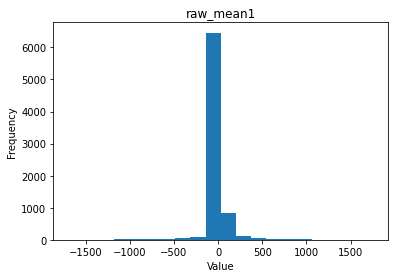

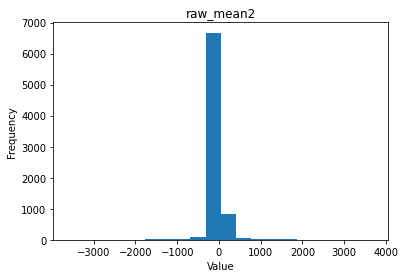

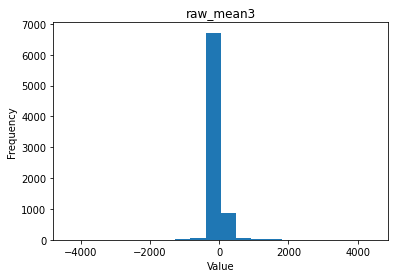

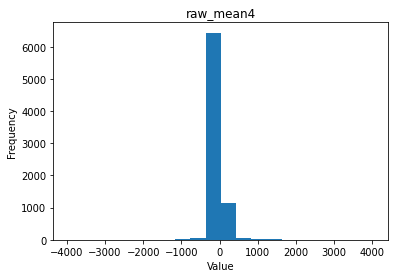

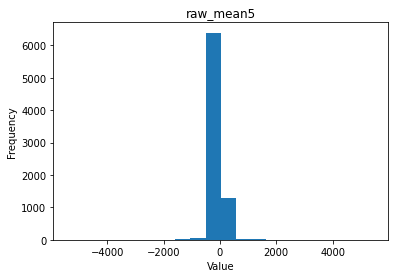

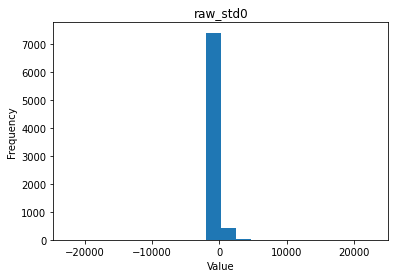

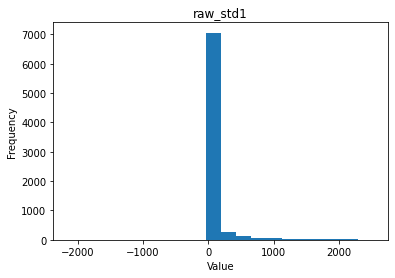

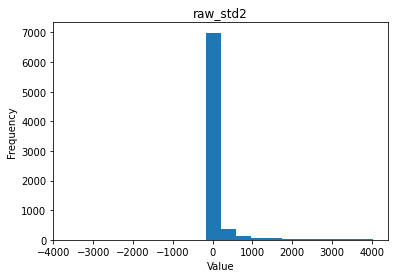

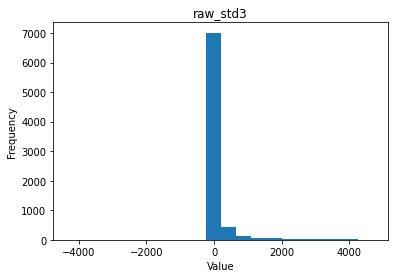

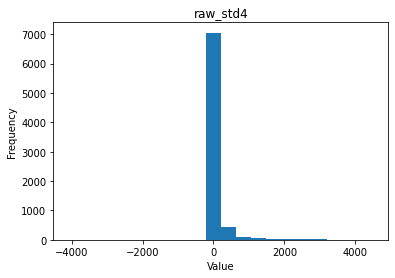

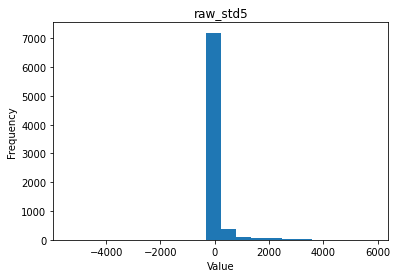

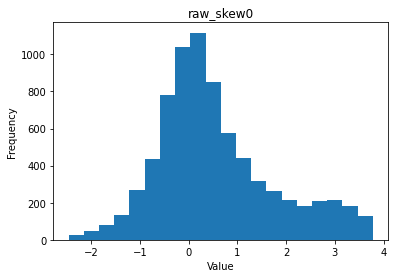

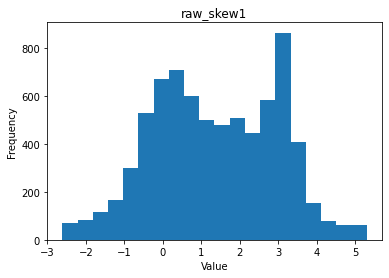

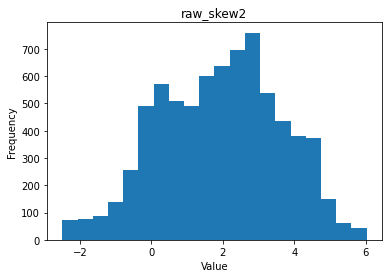

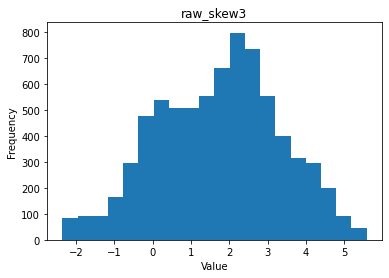

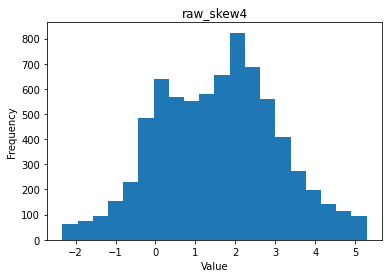

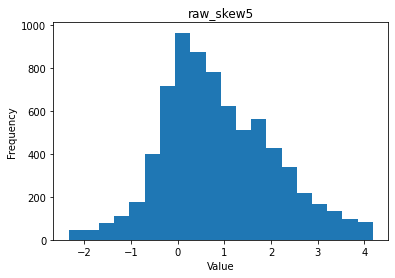

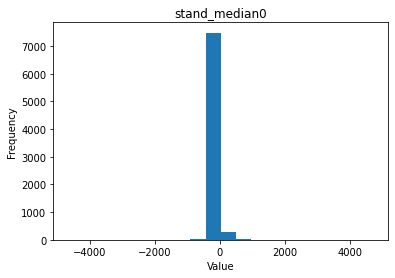

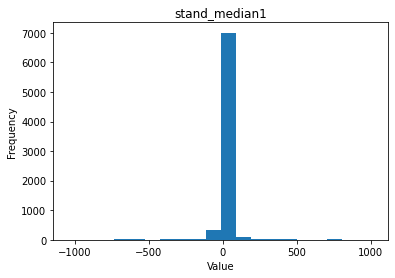

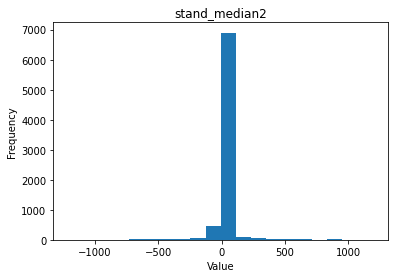

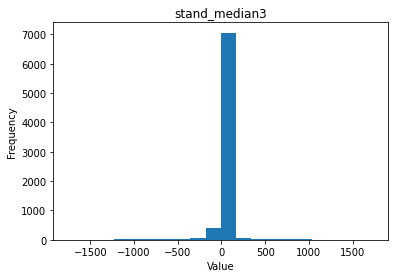

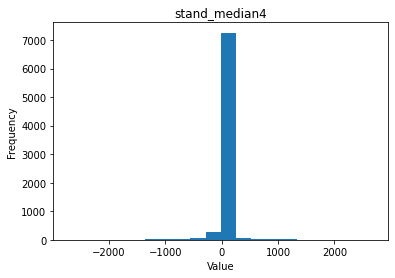

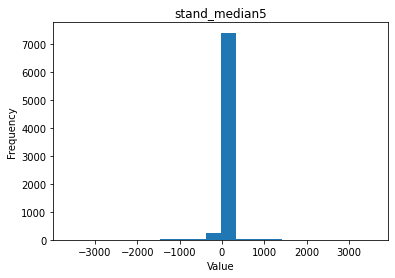

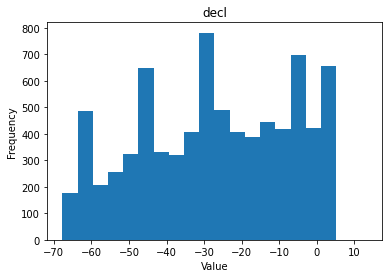

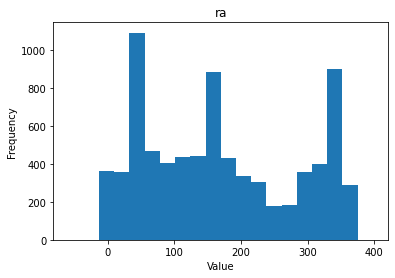

In [ ]:
#Visualize distributions of all features
for ftr in features.columns[1:]:
  
  #Get mean and std of feature
  min = features[ftr].min()
  mean = features[ftr].mean()
  std = features[ftr].std()

  #Plot
  plt.figure()
  plt.hist(features[ftr], bins=20, range=(mean-2*std,mean+2*std))
  plt.title(ftr)
  plt.xlabel('Value')
  plt.ylabel('Frequency')

**Figure 3:** Distribution of All 28 Features. Plots are titled with the feature they represent.

Most of our mean features have distributions tightly centered around zero, but with a few outliers. This is the reason all plots are shown with a range from 2 standard deviations below and 2 above the mean. Otherwise your plots get stretched out real far and we lose some information. Std features are also close to 0, but skew features do seem to follow a normal distribution quite closely. median is close to zero as we would expect on standardized data. Decl and Ra as distributions are strange looking but i'd expect them to converge to uniform as the number of objects tends to infinity. This would mean that I'm assuming celestial bodies are approximately uniformly destributed across the night sky which my limited knowledge of space tells me is false - but I'll lean on 'approximately' here.

In [ ]:
features.head(10)

<font color="red"> FBB not sure what happened at the end - i do not see the output of the last li, but ok otherwise</font>